In [22]:
import re
from math import sqrt
from random import random
import tensorflow as tf
from tqdm import tqdm



class Embedding(tf.keras.Model):
    def __init__(self, file, vocab_size, embedding_size, n_negative=7):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.n_negative = n_negative
        # READING CORPUS
        with open(file, 'r') as file:
            self.text = file.read()
        # CLEANING TEXT
        text = self.text.lower()
        symbols = set(text)
        exclude = '[:0123456789*;,()-\']'
        text = re.sub('?'.join(exclude), '', text)
        text = re.sub('\t?\r?\n', ' ', text)
        words = text.replace('.', '').split(' ')
        # SUBSAMPLING
        frequencies = {word: words.count(word)for word in set(words)}
        n_words = sum(frequencies.values())
        P = lambda x, s=0.001: (sqrt(frequencies[x]/(n_words * s)) + 1) * s * n_words/frequencies[x]
        sentences = [[word for word in sentence.split(' ') if P(word) > random() and word] for sentence in text.split('.')]
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.vocab_size)
        self.tokenizer.fit_on_texts([text.replace('.', ' ')])
        # CREATING DATASET
        dataset = []
        for sentence in sentences:
            sequence = self.tokenizer.texts_to_sequences(sentence)
            pairs, labels = tf.keras.preprocessing.sequence.skipgrams(sequence, 
                                                              vocabulary_size=10000, 
                                                              window_size=1, 
                                                              negative_samples=0.0)
    
            for target, context in pairs:
                if len(context) != 1:
                    context = context[0]
                context = tf.reshape(tf.constant(context, dtype=tf.int64), (1, 1))
                context_negative, true_count, sampled_count = tf.random.log_uniform_candidate_sampler(true_classes=context,
                                                                num_true=1,
                                                                num_sampled=self.n_negative,
                                                                unique=True,
                                                                range_max=10000)
                context = tf.concat([context[0], context_negative], axis=0)
                labels = tf.constant([1] + [0] * self.n_negative, dtype=tf.int64)
                dataset.append(tf.concat([tf.constant([target[0]], dtype=tf.int64), context, labels], axis=0))
        self.dataset = tf.data.Dataset.from_tensor_slices(dataset)
        def preprocess(data):
            data = data.map(lambda x: tf.cast(x, tf.uint32))
            data = data.map(lambda x: (x[0], x[1:2 + n_negative], tf.cast(x[2 + n_negative:], tf.float32)))
            data = data.shuffle(42)
            data = data.cache()
            data = data.batch(32)
            data = data.prefetch(20)
            return data
        self.dataset = self.dataset.apply(preprocess)
        self.optimizer = tf.keras.optimizers.Adam(lr=0.001)
        self.build()
    
    
    def build(self, *args):
        self.W_t = tf.keras.layers.Embedding(self.vocab_size,
                                             self.embedding_size,
                                            input_length=1)
        self.W_c = tf.keras.layers.Embedding(self.vocab_size,
                                             self.embedding_size,
                                            input_length=1)
        self.is_built = True
    
    
    def call(self, target, context):
        embed_t = self.W_t(target)
        embed_c = self.W_c(context)
        return tf.einsum('be,bce->bc', embed_t, embed_c)
    
    
    def loss(self, logits, labels):
        return tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    
    
    def train(self, epochs):
        with tqdm(total=epochs) as bar:
            bar.set_description('JAZZ')
            for epoch in range(epochs):
                for target, context, labels in self.dataset:
                    with tf.GradientTape() as tape:
                        logits = self(target, context)
                        loss   = self.loss(logits, labels)
                    gradients = tape.gradient(loss, self.trainable_weights)
                    self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))



model = Embedding('bible.txt', 10000, 64)

In [23]:
model.train(10)

JAZZ:   0%|                                                                    | 0/10 [1:08:42<?, ?it/s]


In [28]:
with open('bible.txt', 'r') as file:
    text = file.read()

text = text.lower()
symbols = set(text)
exclude = '[:0123456789*;,()-\']'
text = re.sub('?'.join(exclude), '', text)
text = re.sub('\t?\r?\n', ' ', text)
words = text.replace('.', '').split(' ')
frequencies = {word: words.count(word)for word in set(words)}
top_100 = [key for key, val in sorted(frequencies.items(), key=lambda x: -x[1]) if key][:100]
print(top_100)

['the', 'and', 'of', 'to', 'that', 'in', 'he', 'shall', 'unto', 'for', 'i', 'his', 'a', 'lord', 'they', 'be', 'is', 'him', 'not', 'them', 'it', 'with', 'all', 'thou', 'thy', 'was', 'god', 'which', 'my', 'me', 'said', 'but', 'ye', 'their', 'have', 'will', 'thee', 'from', 'as', 'are', 'when', 'this', 'out', 'were', 'upon', 'by', 'man', 'you', 'israel', 'up', 'son', 'there', 'hath', 'king', 'then', 'people', 'came', 'had', 'house', 'into', 'on', 'her', 'come', 'one', 'we', 'children', 'before', 'your', 'also', 'day', 'land', 'an', 'so', 'against', 'men', 'shalt', 'if', 'at', 'let', 'go', 'hand', 'saying', 'us', 'made', 'went', 'no', 'even', 'do', 'now', 'behold', 'saith', 'therefore', 'every', 'these', 'because', 'after', 'our', 'things', 'down', 'or']


In [46]:
import numpy as np

M = model.W_t.weights[0].numpy()

embed = lambda w: model.W_t(model.tokenizer.texts_to_sequences([w])[0][0])

In [81]:
def cosine_distance(A, B):
    return tf.math.acos(tf.reduce_sum(A * B, axis=1)/\
    (tf.math.reduce_euclidean_norm(A) * tf.math.reduce_euclidean_norm(B, axis=1)))

fun_words = ['i', 'shall', 'say', 'the', 'king', 'is', 'naked']
k = 5

for word in fun_words:
    vec = embed(word)
    idx = tf.argsort(cosine_distance(vec, M))[:k,...].numpy()
    print(f"'{word}'\tneighbors:\t{model.tokenizer.sequences_to_texts([idx])[0]}")

'i'	neighbors:	i we they ye indeed
'shall'	neighbors:	shall may should will shalt
'say'	neighbors:	say speak said saith saying
'the'	neighbors:	the of reconciling selah whose
'king'	neighbors:	reign then acts days governor
'is'	neighbors:	was art availeth worketh defileth
'naked'	neighbors:	nurse kittim fornications girding tail


In [83]:
D = np.zeros((100, 100))

M_t = model.W_t(tf.constant(list(map(lambda x: x[0], model.tokenizer.texts_to_sequences(top_100))), dtype=tf.int64))


for i in range(100):
    vec = M_t[i, :]
    D[i, :] = cosine_distance(vec, M_t).numpy()
D

array([[0.        , 1.2485199 , 1.03466034, ..., 1.40143299, 1.45936704,
        1.36391747],
       [1.2485199 , 0.        , 1.21050811, ..., 1.39233828, 1.33684731,
        1.19392002],
       [1.03466034, 1.21050811, 0.        , ..., 1.57219744, 1.71670437,
        1.20317733],
       ...,
       [1.40143299, 1.39233816, 1.57219779, ...,        nan, 1.55785024,
        1.39390993],
       [1.45936704, 1.33684731, 1.71670449, ..., 1.55785024, 0.        ,
        1.49658346],
       [1.36391723, 1.19392014, 1.20317745, ..., 1.39390993, 1.49658346,
        0.        ]])

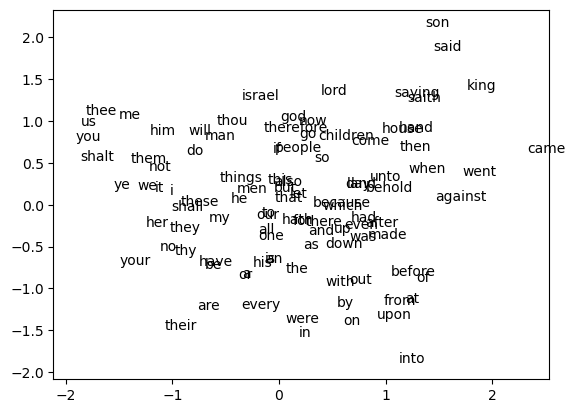

In [97]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

pca = PCA(n_components=2)
c = pca.fit_transform(M_t).T

plt.scatter(c[0,:], c[1,:], s=0)
for i, word in enumerate(top_100):
    plt.annotate(word, (c[0,i], c[1,i]))
plt.show()